In [1]:
import pandas as pd
import pod5 as p5

tsv_file = "egfp_a60_unmod_polyA_position.tsv"
pod_file = "egfp_a60_unmod.pod5"

polyA_df = pd.read_csv(tsv_file, sep='\t')
with p5.Reader(pod_file) as reader:
    pod_data = [(str(read.read_id), read.signal, read.pore) for read in reader.reads()]
pod_df = pd.DataFrame(pod_data, columns=["read_id","signal","pore"])
df = polyA_df.merge(pod_df, on="read_id")

print(df)

FileNotFoundError: [Errno 2] No such file or directory: 'egfp_a60_unmod_polyA_position.tsv'

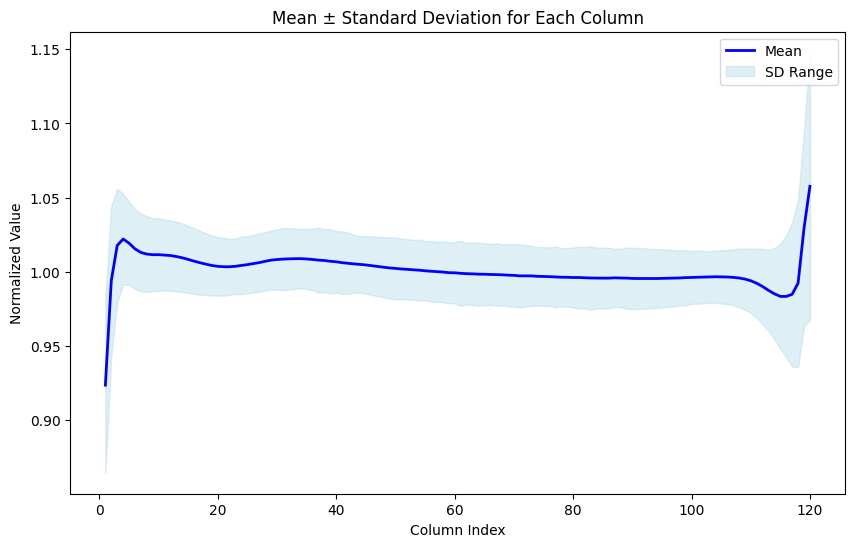

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def process_and_plot_data_from_dataframe(test_data, nwindows):
    # Step 2: Convert the 'signal' column (which should be a string) into a list of numeric values
    # If the signal is already in a list form (not a string), you can skip the str -> list conversion
    if isinstance(test_data['signal'].iloc[0], str):  # Check if it's a string of numbers
        test_data['signal'] = test_data['signal'].apply(lambda x: np.array(list(map(float, x.strip('[]').split(',')))))
    
    # Step 3: Create 'polya_list' with signal slices based on 'start' and 'end'
    polya_list = []
    for i in range(len(test_data)):
        # Slice each signal based on the start and end positions for that row
        polya_list.append(test_data['signal'][i][test_data['start'][i]:test_data['end'][i]])

    # Step 4: Vectorize the data and compute the mean for each window
    list_vectorized = []
    for vector_test in polya_list:
        window_size = len(vector_test) // nwindows
        lwin = np.repeat(window_size, nwindows)
        
        # Account for remaining values that do not fit evenly into windows
        rest = len(vector_test) - window_size * nwindows
        add_positions = np.random.choice(nwindows, rest, replace=False)
        lwin[add_positions] += 1
        
        # Calculate the start and end positions for each window
        window_ends = np.cumsum(lwin)
        window_starts = window_ends - lwin + 1
        
        # Calculate the mean for each window
        vector_mean = [np.mean(vector_test[start-1:end]) for start, end in zip(window_starts, window_ends)]
        list_vectorized.append(vector_mean)

    # Step 5: Combine the list into a matrix
    polya_matrix = np.array(list_vectorized)

    # Step 6: Normalize the matrix by dividing each row by its median
    row_medians = np.median(polya_matrix, axis=1)
    polya_matrix_normalized = polya_matrix / row_medians[:, None]

    # Step 7: Plot the results (Mean ± SD for each column)
    col_means = np.mean(polya_matrix_normalized, axis=0)
    col_sd = np.std(polya_matrix_normalized, axis=0)

    # Create a plot
    x = np.arange(1, nwindows + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(x, col_means, color='blue', label='Mean', linewidth=2)
    plt.fill_between(x, col_means - col_sd, col_means + col_sd, color='lightblue', alpha=0.4, label='SD Range')

    # Adding labels and title
    plt.title('Mean ± Standard Deviation for Each Column')
    plt.xlabel('Column Index')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.show()

# Example usage with your existing DataFrame:
process_and_plot_data_from_dataframe(df, nwindows = 120)  
